In [9]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
import keras

In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
def construct_model(num_class):
    base_model = MobileNetV2(include_top=False, weights=None, input_shape=(224,224,83))
    x=base_model.output
    # Add some new Fully connected layers to 
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    x = Dropout(0.25)(x)
    x=Dense(512,activation='relu')(x) 
    x = Dropout(0.25)(x)
    preds=Dense(num_class, activation='softmax')(x) #final layer with softmax activation

    model=Model(inputs=base_model.input,outputs=preds)
    return model

In [6]:
train_model = construct_model(42)

/home/buikhoi/.local/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 83 input channels.
  str(input_shape[-1]) + ' input channels.')


In [7]:
train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 83) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 83) 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 23904       Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [55]:
class NumpyDataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, folder_link, batch_size=8, shuffle=False):
    self.batch_size = batch_size
    self.folder_link = folder_link
    self.shuffle = shuffle

    self.fetch_data(self.folder_link)

    self.on_epoch_end()
    
  def fetch_data(self, folder_link):
    self.X_data = []
    self.y_true = []
    
    label_counter = 0
    for class_folder in os.listdir(folder_link):
        class_folder_path = folder_link + class_folder + '/'
        for image_file in os.listdir(class_folder_path):
            if '_83.npz' in image_file:
                self.X_data.append(class_folder_path + image_file)
                self.y_true.append(label_counter)
        label_counter += 1
        
    self.X_data = np.array(self.X_data)
    self.y_true = np.array(self.y_true)

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.y_true) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    #print('Index: {}'.format(index))
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#     list_images_temp = [self.images[k] for k in indexes]

    # Generate data
    # X, y = self.__data_generation(list_images_temp)
    X, y = self.__data_generation(indexes)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.y_true))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_idxs):
    '''
    Generate data with the specified batch size
    '''
    # Initialization
    X = np.empty((self.batch_size, 224, 224, 83), dtype=np.uint8)
    y = np.empty((self.batch_size, 42), dtype=np.uint8)

    for i, idx in enumerate(list_idxs):
      temp = np.load(self.X_data[idx])
#       print(self.X_data[idx])
      # X[i,] = cv2.resize(temp['img'].astype(np.float32), (256, 256))
      # y[i,] = cv2.resize(temp['anno'].astype(np.float32), (256, 256))
      X[i,] = temp['data']
      y[i,] = np.zeros((42), np.uint8)
      y[i,][self.y_true[idx]] = 1

    return X, y

In [56]:
datagen = NumpyDataGenerator('./shopee-product-detection-dataset/train/train/')

In [65]:
X, y = datagen.__getitem__(0)

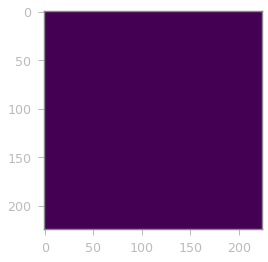

In [36]:
temp.files

[]